# imports

In [1]:
from os import sep
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import Uncertainty as unc
import UncertaintyM as uncM
import Data.data_provider as dp
import matplotlib.pyplot as plt

# Loading data

We consider a standard setting of supervised learning, in which a learner is given access to a set of (i.i.d.) training data $\mathcal{D} \{ (\vec{x}_i , y_i )\}_{i=1}^N \subset \mathcal{X} \times \mathcal{Y}$, where $\mathcal{X}$ is an instance space and $\mathcal{Y}$ the set of outcomes that can be associated with an instance. In particular, we focus on the classification scenario, where $\mathcal{Y}=\{y_1, \ldots, y_K\}$ consists of a finite set of class labels, with binary classification ($\mathcal{Y} = \{0,1\}$) as an important special case.

In [2]:
data_name = "spambase"
features, target = dp.load_data(data_name)

# split and shuffel the data
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.4, shuffle=True, random_state=1)
X_test, X_valid, y_test, y_valid = train_test_split(X_test, y_test, test_size=0.5, shuffle=True, random_state=1)

# Train the ensemble

In this section, given the data, we train a normal random forest classifier 

In [3]:
model = RandomForestClassifier(max_depth=10, n_estimators=10, random_state=1)
model.fit(X_train, y_train) # remove keys when fiting the model

predictions = model.predict(X_test)
print("model test score = ", model.score(X_test, y_test))

model test score =  0.9217391304347826


# Uncertainty quantification

In the literature on uncertainty, two inherently different sources of uncertainty are commonly distinguished, referred to as aleatoric and epistemic. Broadly speaking, aleatoric (aka statistical) uncertainty refers to the notion of randomness---coin flipping is a prototypical example. 
As opposed to this, epistemic (aka systematic) uncertainty refers to uncertainty caused by a lack of knowledge, i.e., it relates to the epistemic state of an agent. This uncertainty can in principle be reduced on the basis of additional information. In other words, epistemic uncertainty refers to the reducible part of the (total) uncertainty, whereas aleatoric uncertainty refers to the non-reducible part. 

Here the uncertainties are calculated for the test instances. For more detail on uncertainty calculation for random forest please see our paper "Aleatoric and epistemic uncertainty with random forests."


In [4]:
total_uncertainty, epistemic_uncertainty, aleatoric_uncertainty = unc.model_uncertainty(model, X_test, X_train, y_train)

# Accuracy Rejection plot

The empirical evaluation of methods for quantifying uncertainty is a non-trivial problem. In fact, unlike for the prediction of a target variable, the data does normally not contain information about any sort of ``ground truth'' uncertainty. What is often done, therefore, is to evaluate predicted uncertainties indirectly, that is, by assessing their usefulness for improved prediction and decision making. Adopting an approach of that kind, we produced accuracy-rejection curves, which depict the accuracy of a predictor as a function of the percentage of rejections: A classifier, which is allowed to abstain on a certain percentage $p$ of predictions, will predict on those $(1-p)$\,\% on which it feels most certain. Being able to quantify its own uncertainty well, it should improve its accuracy with increasing $p$, hence the accuracy-rejection curve should be monotone increasing (unlike a flat curve obtained for random abstention). 


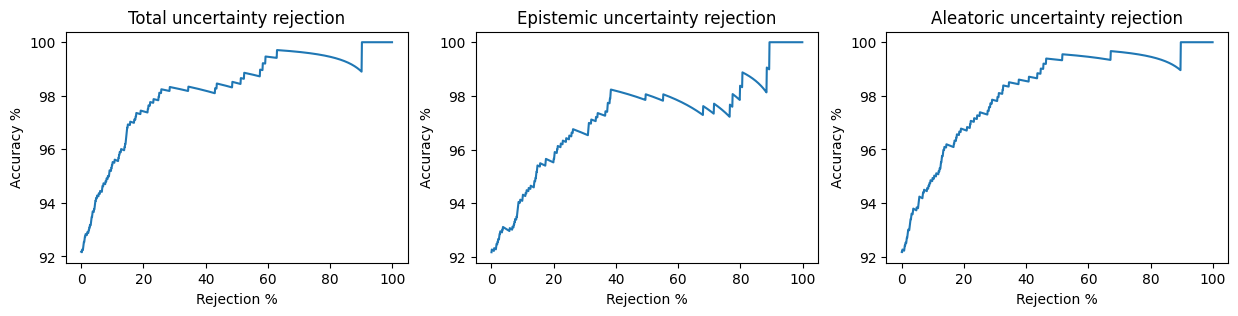

In [5]:
fig, axs = plt.subplots(1,3)
fig.set_figheight(3)
fig.set_figwidth(15)

avg_acc, avg_min, avg_max, avg_random ,steps = uncM.accuracy_rejection2(predictions.reshape((1,-1)), y_test.reshape((1,-1)), total_uncertainty.reshape((1,-1)))
axs[0].plot(steps, avg_acc*100)
axs[0].set_title("Total uncertainty rejection")

avg_acc, avg_min, avg_max, avg_random ,steps = uncM.accuracy_rejection2(predictions.reshape((1,-1)), y_test.reshape((1,-1)), epistemic_uncertainty.reshape((1,-1)))
axs[1].plot(steps, avg_acc*100)
axs[1].set_title("Epistemic uncertainty rejection")

avg_acc, avg_min, avg_max, avg_random ,steps = uncM.accuracy_rejection2(predictions.reshape((1,-1)), y_test.reshape((1,-1)), aleatoric_uncertainty.reshape((1,-1)))
axs[2].plot(steps, avg_acc*100)
axs[2].set_title("Aleatoric uncertainty rejection")

for i in range(3):
    axs[i].set(xlabel="Rejection %", ylabel="Accuracy %")

fig
